In [1]:
# !pip install mvlearn==0.5.0 wordcloud==1.9.3 matplotlib==3.3.4 distinctipy==1.3.4 networkx==3.2.1  umap==0.1.1 hoggorm==0.13.3 adilsm==0.0.7 scipy==1.9.1
# !pip install mvlearn==0.5.0 wordcloud==1.9.3 matplotlib==3.3.4 distinctipy==1.3.4 networkx==3.2.1  umap==0.1.1 hoggorm==0.13.3 adilsm==0.0.7 scipy==1.9.1

# scipy==1.12.0 not used (due to changes in SVDS) to reproduce presented results in ref paper

In [2]:
# !pip install -e ..

In [3]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import adilsm.adilsm as ilsm
from adnmtf import NMF # type: ignore
from sklearn.linear_model import LinearRegression

RESULTS_PATH = './'

df = pd.read_csv(RESULTS_PATH + r'ALL-AML Brunet.csv')
m0 = df.values[:,2:].astype(np.float_)

(n,p) = np.shape(m0)

# for Brunet only:
m0 = np.log2(df.values[:,2:].astype(np.float_))
m0-=np.repeat(np.min(m0, axis=0)[:,np.newaxis].T, n, axis=0)

m0 = np.random.permutation(m0.T).T

(n,p) = np.shape(m0)

adilsm version=0.0.9


In [4]:
n_slices = 10
n_comp = 4
p_slice = int(p/n_slices)
Xs=[m0[:,i*p_slice:(i+1)*p_slice] for i in range(n_slices)]

In [5]:
my_nmfmodel = NMF(n_components=n_comp, leverage=None, max_iter=200, tol=1.e-6, verbose=-1)
result = my_nmfmodel.fit_transform(m0)

w_nmf = result.w
h_nmf = result.h

Ws = []
Hs = []
for i in range(n_slices):
    result = my_nmfmodel.fit_transform(Xs[i])
    Ws.append(result.w)
    Hs.append(result.h)

In [6]:
# Perform ISM on NMF slices
n_embedding, n_themes = [n_comp,n_comp]

ilsm_result = ilsm.ism(Ws, n_embedding, n_themes, norm_columns=False, update_h_ism=True,
                                    max_iter_mult=200, fast_mult_rules=True, sparsity_coeff=.8)
hv = ilsm_result['HV']
hv_sparse = ilsm_result['HV_SPARSE']
hhii = ilsm_result['HHII']
w_ism = ilsm_result['W']
h_ism = ilsm_result['H']
q_ism = ilsm_result['Q']
Xs_emb = ilsm_result['EMBEDDING']
Xs_norm = ilsm_result['NORMED_VIEWS']

# Chain-multiplication to retrieve view-mapping to original matrix
h_fnmf = np.empty((0, 4))
for i in range(n_slices):
    h_fnmf = np.vstack((h_fnmf, Hs[i] @ hv[i]))

# normalize w_ism and h_fnmf by max column in w_ism as in w_nmf
max_values = np.max(w_ism, axis=0)
w_fnmf = np.divide(w_ism, np.where(max_values == 0, 1, max_values))
h_fnmf = np.multiply(h_fnmf, max_values)

# Calculate error
error = np.linalg.norm(m0 -  w_fnmf @ h_fnmf.T) / np.linalg.norm(m0)
print('error(federated nmf): ',round(error, 2))

error = np.linalg.norm(m0 -  w_nmf @ h_nmf.T) / np.linalg.norm(m0)
print('error(standard nmf): ',round(error, 2))


error ism before straightening:  0.25
error ism after straightening:  0.25
error(federated nmf):  0.42
error(standard nmf):  0.4


error ism before straightening:  0.04
error ism after straightening:  0.04


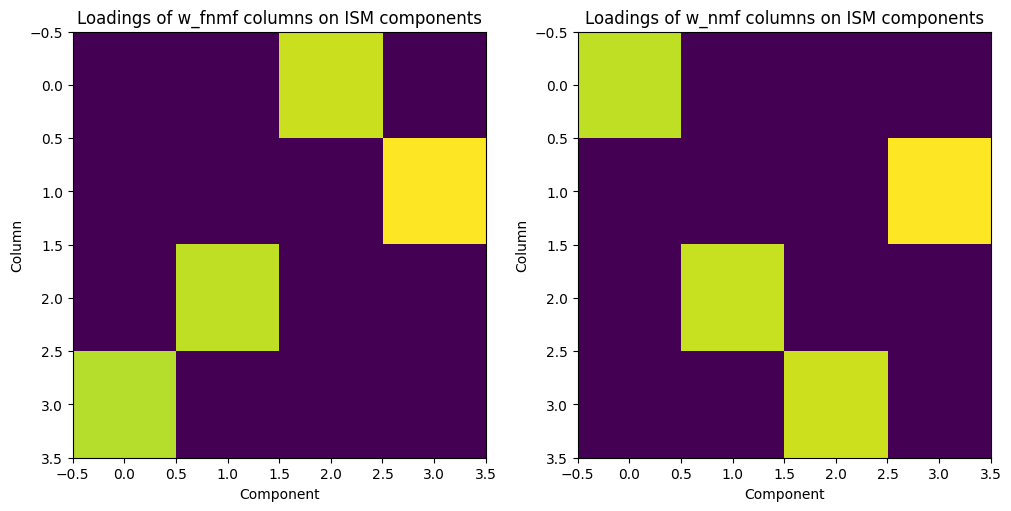

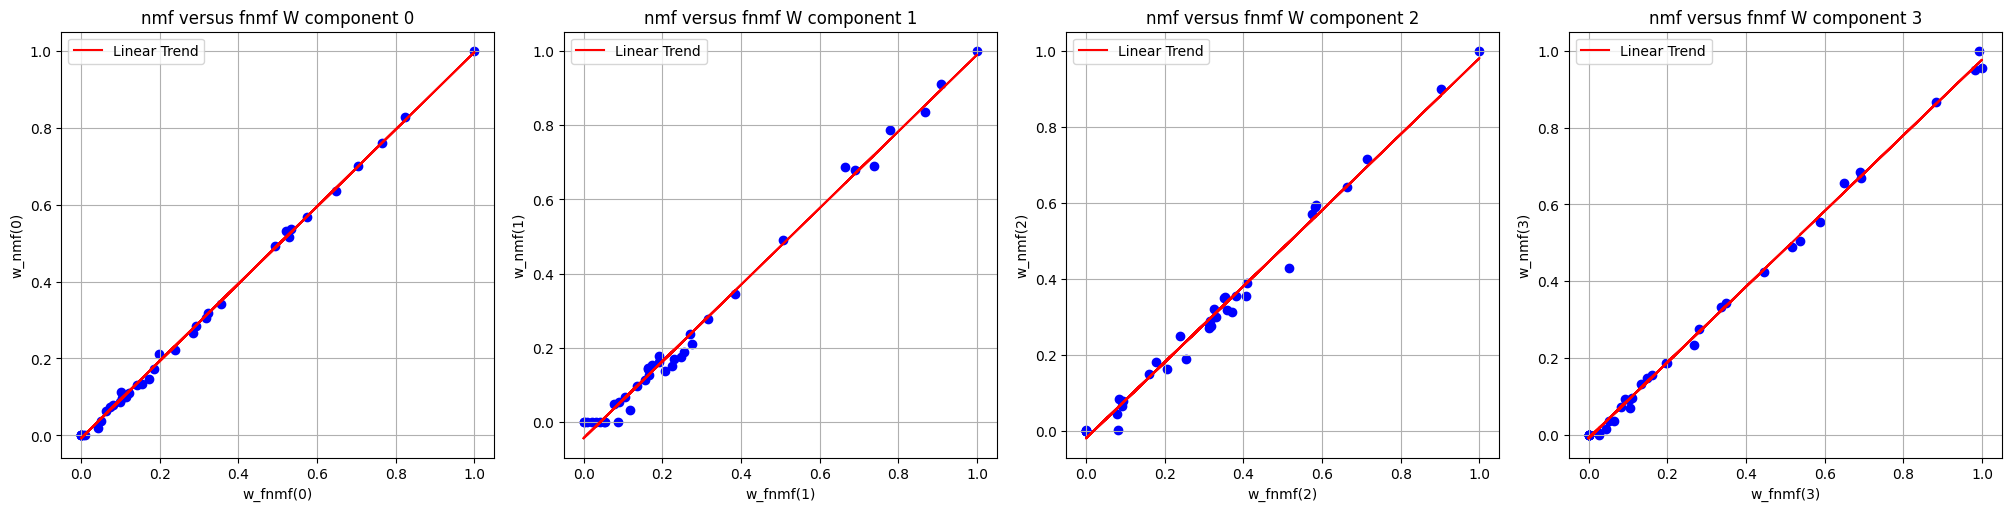

In [7]:
# Perform ISM on reduced matrices w_fnmf and w_nmf
# ISM is expected to recognize that w_fnmf and w_nmf convey the same information up to some noise,
# albeit with the columns of either matrix swapped around.
# Heatmaps of the loadings of w_fnmf and w_nmf columns on ISM components show the effective permutation. 

Xs = [w_fnmf, w_nmf]
n_embedding, n_themes = [n_comp,n_comp]

ilsm_result = ilsm.ism(Xs, n_embedding, n_themes, norm_columns=False, update_h_ism=True,
                                    max_iter_mult=200, fast_mult_rules=True, sparsity_coeff=.8)
hv = ilsm_result['HV']
hv_sparse = ilsm_result['HV_SPARSE']
hhii = ilsm_result['HHII']
w_ism = ilsm_result['W']
h_ism = ilsm_result['H']
q_ism = ilsm_result['Q']
Xs_emb = ilsm_result['EMBEDDING']
Xs_norm = ilsm_result['NORMED_VIEWS']

fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

ax[0].imshow(hv[0], cmap='viridis', aspect='auto')
# Add labels and title
ax[0].set_xlabel('Component')
ax[0].set_ylabel('Column')
ax[0].set_title('Loadings of w_fnmf columns on ISM components')

ax[1].imshow(hv[1], cmap='viridis', aspect='auto')
# Add labels and title
ax[1].set_xlabel('Component')
ax[1].set_ylabel('Column')
ax[1].set_title('Loadings of w_nmf columns on ISM components')

# Show the plot
plt.show()

# Apply back-permutation to obtain comparable components and plot scatterplot
w_fnmf_perm = w_fnmf[:,np.argmax(hv[0], axis=0)]
w_nmf_perm = w_nmf[:,np.argmax(hv[1], axis=0)]

regressor = LinearRegression()

fig, ax = plt.subplots(1, n_comp, figsize=(20, 5), constrained_layout=True)
for i in range(4):
    regressor.fit(w_fnmf_perm[:,i].reshape(-1, 1), w_nmf_perm[:,i])
    ax[i].plot(w_fnmf_perm[:,i], regressor.predict(w_fnmf_perm[:,i].reshape(-1, 1)), color='r', label='Linear Trend')
    ax[i].scatter(w_fnmf_perm[:,i], w_nmf_perm[:,i], color='b')
    ax[i].set_xlabel('w_fnmf('+str(i)+')')
    ax[i].set_ylabel('w_nmf('+str(i)+')')
    ax[i].set_title('nmf versus fnmf W component '+str(i))
    ax[i].grid(True)
    ax[i].legend()

plt.show()